# Baseline tarea 1

-----------------------------




## Importar librerías y utiles

In [11]:
import pandas as pd
import shutil

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, cohen_kappa_score, classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection
from nltk.tokenize import TweetTokenizer
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from nltk.sentiment.util import mark_negation
import matplotlib.pyplot as plt
import os
import numpy as np

## Datos

### Obtener los datasets desde el github del curso

In [2]:
train = {
    'anger': pd.read_csv('https://raw.githubusercontent.com/dccuchile/CC6205/master/assignments/assignment_1/data/train/anger-train.txt', sep='\t', names=['id', 'tweet', 'class', 'sentiment_intensity']),
    'fear': pd.read_csv('https://raw.githubusercontent.com/dccuchile/CC6205/master/assignments/assignment_1/data/train/fear-train.txt', sep='\t', names=['id', 'tweet', 'class', 'sentiment_intensity']),
    'joy': pd.read_csv('https://raw.githubusercontent.com/dccuchile/CC6205/master/assignments/assignment_1/data/train/joy-train.txt', sep='\t', names=['id', 'tweet', 'class', 'sentiment_intensity']),
    'sadness': pd.read_csv('https://raw.githubusercontent.com/dccuchile/CC6205/master/assignments/assignment_1/data/train/sadness-train.txt', sep='\t', names=['id', 'tweet', 'class', 'sentiment_intensity'])
}

target = {
    'anger': pd.read_csv('https://raw.githubusercontent.com/dccuchile/CC6205/master/assignments/assignment_1/data/target/anger-target.txt', sep='\t', names=['id', 'tweet', 'class', 'sentiment_intensity'], na_values=['NONE']),
    'fear': pd.read_csv('https://raw.githubusercontent.com/dccuchile/CC6205/master/assignments/assignment_1/data/target/fear-target.txt', sep='\t', names=['id', 'tweet', 'class', 'sentiment_intensity'], na_values=['NONE']),
    'joy': pd.read_csv('https://raw.githubusercontent.com/dccuchile/CC6205/master/assignments/assignment_1/data/target/joy-target.txt', sep='\t', names=['id', 'tweet', 'class', 'sentiment_intensity'], na_values=['NONE']),
    'sadness': pd.read_csv('https://raw.githubusercontent.com/dccuchile/CC6205/master/assignments/assignment_1/data/target/sadness-target.txt', sep='\t', names=['id', 'tweet', 'class', 'sentiment_intensity'], na_values=['NONE'])
}

### Analizar los datos 

Imprimir la cantidad de tweets de cada dataset, según su intensidad de sentimiento

In [3]:
def get_group_dist(group_name, train):
    print(group_name, "\n",
          train[group_name].groupby('sentiment_intensity').count())


for key in train:
    get_group_dist(key, train)

anger 
                       id  tweet  class
sentiment_intensity                   
high                 163    163    163
low                  161    161    161
medium               617    617    617
fear 
                       id  tweet  class
sentiment_intensity                   
high                 270    270    270
low                  288    288    288
medium               699    699    699
joy 
                       id  tweet  class
sentiment_intensity                   
high                 195    195    195
low                  219    219    219
medium               488    488    488
sadness 
                       id  tweet  class
sentiment_intensity                   
high                 197    197    197
low                  210    210    210
medium               453    453    453


## Clasificar

In [4]:
# Metrica de evaluación. No tocar...
def auc(test_set, predicted_set):
    high_predicted = np.array([prediction[2] for prediction in predicted_set])
    medium_predicted = np.array(
        [prediction[1] for prediction in predicted_set])
    low_predicted = np.array([prediction[0] for prediction in predicted_set])

    high_test = np.where(test_set == 'high', 1.0, 0.0)
    medium_test = np.where(test_set == 'medium', 1.0, 0.0)
    low_test = np.where(test_set == 'low', 1.0, 0.0)

    auc_high = roc_auc_score(high_test, high_predicted)
    auc_med = roc_auc_score(medium_test, medium_predicted)
    auc_low = roc_auc_score(low_test, low_predicted)

    auc_w = (low_test.sum() * auc_low + medium_test.sum() * auc_med +
             high_test.sum() * auc_high) / (
                 low_test.sum() + medium_test.sum() + high_test.sum())
    return auc_w    

### Dividir el dataset en entrenamiento y prueba

In [5]:
def split_dataset(dataset):
    # Dividir el dataset en train set y test set
    X_train, X_test, y_train, y_test = train_test_split(
        dataset.tweet,
        dataset.sentiment_intensity,
        shuffle=True,
        test_size=0.33)
    return X_train, X_test, y_train, y_test

### Definir el clasificador

Consejo para el vectorizador: investigar los modulos de `nltk`, en particular, `TweetTokenizer`, `mark_negation`. También, el parámetro ngram_range para clasificadores no bayesianos.

Consejo para el clasificador: investigar otros clasificadores mas efectivos que naive bayes. Ojo q naive bayes no debería usarse con n-gramas, ya que rompe el supuesto de independencia.


In [25]:
# Definimos el pipeline con el vectorizador y el clasificador.
def get_classifier(n_estimators=100):
     # Inicializamos el Vectorizador para transformar las oraciones a BoW 
    vectorizor = TfidfVectorizer(ngram_range = (1,3), stop_words='english')
    #vectorizor.tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True).tokenize
    #vectorizor.preprocessor = mark_negation
    # Inicializamos el Clasificador.
    rfc = RandomForestClassifier(n_estimators=n_estimators)
    
    # Establecer el pipeline.
    text_clf = Pipeline([('vect', vectorizor), ('clf', rfc)])
    return text_clf

### Definir evaluación

Esta función imprime la matriz de confusión, el reporte de clasificación y las metricas usadas en la competencia:


- `auc`
- `kappa`
- `accuracy`

In [7]:
def evaulate(predicted, y_test, labels):
    # Importante: al transformar los arreglos de probabilidad a clases,
    # entregar el arreglo de clases aprendido por el clasificador. 
    # (que comunmente, es distinto a ['low', 'medium', 'high'])
    predicted_labels = [labels[np.argmax(item)] for item in predicted]
    
    # Confusion Matrix
    print('Confusion Matrix for {}:\n'.format(key))

    # Classification Report
    print(
        confusion_matrix(y_test,
                         predicted_labels,
                         labels=['low', 'medium', 'high']))

    print('\nClassification Report')
    print(
        classification_report(y_test,
                              predicted_labels,
                              labels=['low', 'medium', 'high']))

    # AUC
    print("auc: ", auc(y_test, predicted))

    # Kappa
    print("kappa:", cohen_kappa_score(y_test, predicted_labels))

    # Accuracy
    print("accuracy:", accuracy_score(y_test, predicted_labels), "\n")

    print('------------------------------------------------------\n\n')

## cross validation 

generar cross validation para manejar estadisticas

In [8]:
def statisticsCV(clf, dataset, n_cv=10, eval_metric='accuracy'):
    metrics = cross_val_score(clf, dataset.tweet, dataset.sentiment_intensity, cv= n_cv, scoring=eval_metric)
    mean = np.mean(metrics)
    std = np.std(metrics)
    return mean, std, eval_metric

## Graficos de metricas vs parameters

In [30]:
def plot_statistics(dataset, key, n_cv=10, eval_metric='accuracy'):
    rfc = get_classifier()
    n_est = np.arange(100,1000,100)
    scores = list()
    scores_std = list()
    print("metricas: "+eval_metric)
    for n in n_est:
        rfc = get_classifier(n)
        mean, std, eval_metric = statisticsCV(rfc, dataset, n_cv, eval_metric)
        scores.append(mean)
        scores_std.append(std)
        print('sentiment: {} | abscisa: {}, | mean: {} | std: {}  \n'.format(key, n, mean, std))
    plt.figure()
    plt.plot(n_est, scores)
    plt.plot(n_est, np.array(scores) + np.array(scores_std), 'b--')
    plt.plot(n_est, np.array(scores) - np.array(scores_std), 'b--')
    locs, labels = plt.yticks()
    plt.ylabel("CV score "+ key)
    plt.xlabel("Parameter " +eval_metric)
    plt.show()

metricas: accuracy
sentiment: anger | abscisa: 100, | mean: 0.6673335858395162 | std: 0.0516056747841841  

sentiment: anger | abscisa: 200, | mean: 0.6758248928618626 | std: 0.047574278210761524  

sentiment: anger | abscisa: 300, | mean: 0.6715704783300925 | std: 0.04930756625353788  

sentiment: anger | abscisa: 400, | mean: 0.6683539940027815 | std: 0.04565193296254678  

sentiment: anger | abscisa: 500, | mean: 0.6705047803117548 | std: 0.04694371247362466  

sentiment: anger | abscisa: 600, | mean: 0.6737184327940242 | std: 0.04803542822251744  

sentiment: anger | abscisa: 700, | mean: 0.6726102767656553 | std: 0.048027438950922194  

sentiment: anger | abscisa: 800, | mean: 0.6694843721484893 | std: 0.04656775657681548  

sentiment: anger | abscisa: 900, | mean: 0.6715686100989887 | std: 0.047880035559195504  



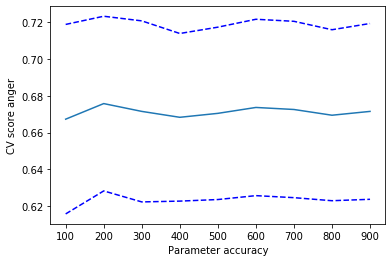

metricas: accuracy
sentiment: fear | abscisa: 100, | mean: 0.5883791841366371 | std: 0.057758392933901094  

sentiment: fear | abscisa: 200, | mean: 0.5932290945309024 | std: 0.050665422214585885  

sentiment: fear | abscisa: 300, | mean: 0.5956112469886597 | std: 0.04843137389731913  

sentiment: fear | abscisa: 400, | mean: 0.5963540748575122 | std: 0.053297367404797985  

sentiment: fear | abscisa: 500, | mean: 0.5963912772384645 | std: 0.04897358952619331  

sentiment: fear | abscisa: 600, | mean: 0.5955724248319105 | std: 0.056069494849427755  

sentiment: fear | abscisa: 700, | mean: 0.5900028487069073 | std: 0.0519570206126863  

sentiment: fear | abscisa: 800, | mean: 0.5987986313091251 | std: 0.04820081931543117  

sentiment: fear | abscisa: 900, | mean: 0.5963544945565039 | std: 0.04827212667959661  



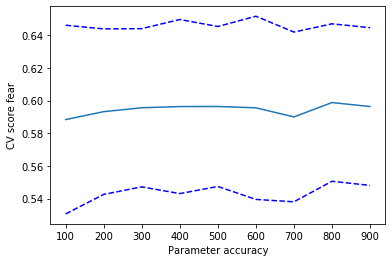

metricas: accuracy
sentiment: joy | abscisa: 100, | mean: 0.6079729294971965 | std: 0.07507644301915757  

sentiment: joy | abscisa: 200, | mean: 0.6036262013461203 | std: 0.06681993794701903  

sentiment: joy | abscisa: 300, | mean: 0.6013534740733932 | std: 0.07148931540235912  

sentiment: joy | abscisa: 400, | mean: 0.6001654308504661 | std: 0.0729615581188314  

sentiment: joy | abscisa: 500, | mean: 0.601277639897458 | std: 0.07292654564353367  

sentiment: joy | abscisa: 600, | mean: 0.5980167703322404 | std: 0.0717164258526026  

sentiment: joy | abscisa: 700, | mean: 0.6001929558476575 | std: 0.07125962623817704  

sentiment: joy | abscisa: 800, | mean: 0.5980156723963599 | std: 0.07120776978194776  

sentiment: joy | abscisa: 900, | mean: 0.6035975784130486 | std: 0.0693450448195977  



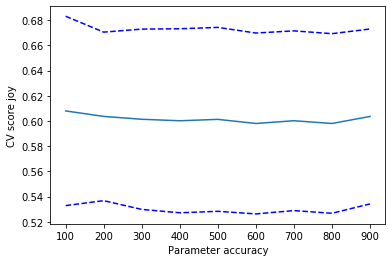

metricas: accuracy
sentiment: sadness | abscisa: 100, | mean: 0.5082285765850711 | std: 0.0693473279354204  

sentiment: sadness | abscisa: 200, | mean: 0.5130286026131177 | std: 0.06798763243313276  

sentiment: sadness | abscisa: 300, | mean: 0.5038016908408287 | std: 0.06753107576557049  

sentiment: sadness | abscisa: 400, | mean: 0.5084857570109981 | std: 0.06606491977656387  

sentiment: sadness | abscisa: 500, | mean: 0.516623941382875 | std: 0.06960992443219426  

sentiment: sadness | abscisa: 600, | mean: 0.5083723140161032 | std: 0.06369365340272716  

sentiment: sadness | abscisa: 700, | mean: 0.5025873965323767 | std: 0.06486316776871086  

sentiment: sadness | abscisa: 800, | mean: 0.5177088014084611 | std: 0.060049590504063714  

sentiment: sadness | abscisa: 900, | mean: 0.5131407871765218 | std: 0.07195078185209113  



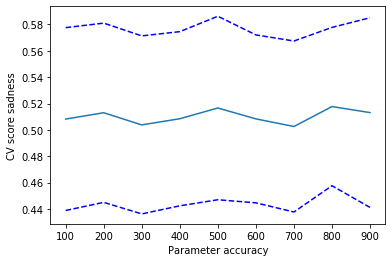

In [32]:
for key in train:
    plot_statistics(train[key], key, 20)

### Ejecutar el clasificador para cierto dataset

Clasifica un dataset. Retorna el modelo ya entrenado mas sus labels asociadas.


In [1]:
def classify(dataset, key):

    X_train, X_test, y_train, y_test = split_dataset(dataset)
    text_clf = get_classifier()

    # Entrenar el clasificador
    text_clf.fit(X_train, y_train)

    # Predecir las probabilidades de intensidad de cada elemento del set de prueba.
    predicted = text_clf.predict_proba(X_test)

    # Obtener las clases aprendidas.
    learned_labels = text_clf.classes_

    # Evaluar -> baseline
    # evaulate(predicted, y_test, learned_labels)
    
    # Estadisticas CV
    mean, std, eval_metric = statisticsCV(text_clf, dataset, n_iter=10)
    print('{} for {}:\n'.format(eval_metric, key))
    print("mean: ", mean, "|  std: ", std)
    print('\n')
    
    return text_clf, learned_labels

### Ejecutar el clasificador por cada dataset


In [2]:
classifiers = []
learned_labels_array = []

# Por cada llave en train ('anger', 'fear', 'joy', 'sadness')
for key in train:
    classifier, learned_labels = classify(train[key], key)
    classifiers.append(classifier)
    learned_labels_array.append(learned_labels)

NameError: name 'train' is not defined

## Predecir target set

In [ ]:
def predict_target(dataset, classifier, labels):
    # Predecir las probabilidades de intensidad de cada elemento del target set.
    predicted = pd.DataFrame(classifier.predict_proba(dataset.tweet), columns=labels)
    # Agregar ids
    predicted['id'] = dataset.id.values
    # Reordenar
    predicted = predicted[['id', 'low', 'medium', 'high']]
    return predicted

### Ejecutar la predicción y guardar archivos.

In [ ]:
predicted_target = {}

if (not os.path.isdir('./predictions')):
    os.mkdir('./predictions')

else:
    # Eliminar predicciones anteriores:
    shutil.rmtree('./predictions')
    os.mkdir('./predictions')

for idx, key in enumerate(target):
    # Predecir el target set
    predicted_target[key] = predict_target(target[key], classifiers[idx],
                                           learned_labels_array[idx])
    # Guardar predicciones
    predicted_target[key].to_csv('./predictions/{}-pred.txt'.format(key),
                                 sep='\t',
                                 header=False,
                                 index=False)

# Crear archivo zip
a = shutil.make_archive('predictions', 'zip', './predictions')